In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/tp2datostrain/train.csv
/kaggle/input/tp2datostrain/test.csv
/kaggle/input/pingsound/PING - Sound effect.mp3
/kaggle/input/tpdatostest/test.csv


In [2]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder, CountEncoder
import matplotlib.pyplot as plt

In [3]:
from IPython.display import Audio

# Cargo los archivos
sound_file = '/kaggle/input/pingsound/PING - Sound effect.mp3'
def ping():
    display(Audio(sound_file, autoplay=True))

In [82]:
df = pd.read_csv("/kaggle/input/tp2datostrain/train.csv")
df.drop(columns=['id'], inplace=True)

In [83]:
train = df.copy()


Relleno los nans y verifico la feature importance utilizando Random Forest

In [6]:
#Las variables categoricas las relleno indicando que estan vacias
train['ciudad'] = SimpleImputer(strategy='constant', fill_value='ciudadVacia').fit_transform(train[['ciudad']])
train['provincia'] = SimpleImputer(strategy='constant', fill_value='provinciaVacia').fit_transform(train[['provincia']])
train['tipodepropiedad'] = SimpleImputer(strategy='constant', fill_value='tipoVacio').fit_transform(train[['tipodepropiedad']])

In [7]:
#EL titulo y la descripcion las junto y las reemplazo por el largo del texto
train.titulo.fillna('', inplace=True)
train.descripcion.fillna('', inplace=True)
train['texto'] = train['descripcion'] + train['titulo']
train['texto'] = train.texto.str.len()
train.drop(columns=['descripcion', 'titulo'], inplace=True)

In [8]:
#La direccion la dropeo
train.drop(columns = ['direccion'], inplace=True)

In [9]:
#Las categoricas las reemplazo por la cantidad de apariciones
train['ciudad'] = CountEncoder().fit_transform(train['ciudad'])
train['provincia'] = CountEncoder().fit_transform(train['provincia'])
train['tipodepropiedad'] = CountEncoder().fit_transform(train['tipodepropiedad'])

In [10]:
#La antiguedad la reemplazo por el promedio de antiguedad para la ciudad
aux = train[['antiguedad', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'antiguedad':'mean'})
antiguedades = aux.T.to_dict('records').copy()
antiguedades = antiguedades[0]
train.antiguedad.fillna(train.ciudad.map(antiguedades), inplace = True)
train['antiguedad'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['antiguedad']])

In [11]:
#La cantidad de habitaciones las reemplazo por la mediana de habitaciones por tipo de propiedad
aux = train[['tipodepropiedad', 'habitaciones']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('tipodepropiedad').agg({'habitaciones':'median'})
habts = aux.T.to_dict('records').copy()
habts = habts[0]
train.habitaciones.fillna(train.tipodepropiedad.map(habts), inplace = True)
train['habitaciones'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['habitaciones']])

In [12]:
#Los garages supongo que no tiene si es nan
train.garages.fillna(0, inplace=True)
#Los banos relleno con 1 ya que es la cantidad minima de banos que tiene normalmente una propiedad
train.banos.fillna(1, inplace=True)

In [13]:
#Para los metros cubiertos y totales relleno con 0 y arreglo para que metros totales sea siempre mayor a metros cubiertos
aux = train.copy()
aux.metrostotales.fillna(0, inplace=True)
aux.metroscubiertos.fillna(0, inplace =True)
aux['metrostotalesCorregidos'] = aux[['metrostotales', 'metroscubiertos']].max(axis=1)
aux['metroscubiertosCorregidos'] = aux[['metrostotales', 'metroscubiertos']].min(axis=1)
train['metrostotales'] = aux['metrostotalesCorregidos']
train['metroscubiertos'] = aux['metroscubiertosCorregidos']

In [14]:
#El idzona lo relleno con la mediana en la ciudad
aux2 = train[['idzona', 'ciudad']].copy()
aux2.dropna(inplace = True)
aux2 = aux2.groupby('ciudad').agg({'idzona':'median'})
ids = aux2.T.to_dict('records').copy()
ids = ids[0]
train.idzona.fillna(train.ciudad.map(ids), inplace = True)
train['idzona'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['idzona']])

In [15]:
#Lo mismo hago para la latitud y la longitud
aux = train[['lat', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'lat':'mean'})
lats = aux.T.to_dict('records').copy()
lats = lats[0]
train.lat.fillna(train.ciudad.map(lats), inplace = True)
train['lat'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['lat']])

aux = train[['lng', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'lng':'mean'})
lngs = aux.T.to_dict('records').copy()
lngs = lngs[0]
train.lat.fillna(train.ciudad.map(lngs), inplace = True)
train['lng'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['lng']])

In [16]:
#La fecha la separo en 3 columnsa de anio, mes y dia
train['fecha'] = pd.to_datetime(train['fecha'])
train['dia'] = train.fecha.dt.day
train['mes'] = train.fecha.dt.month
train['anio'] = train.fecha.dt.year


In [17]:
train['publicacionesPorCiudad'] = CountEncoder().fit_transform(train['ciudad'])
train['publicacionesPorProvincia'] = CountEncoder().fit_transform(train['provincia'])
train['publicacionesPorTipo'] = CountEncoder().fit_transform(train['tipodepropiedad'])
train['publicacionesPorZona'] = CountEncoder().fit_transform(train['idzona'])
train['publicacionesPorBanos'] = CountEncoder().fit_transform(train['banos'])
train['publicacionesPorHabitaciones'] = CountEncoder().fit_transform(train['habitaciones'])
train['publicacionesPorAntiguedad'] = CountEncoder().fit_transform(train['antiguedad'])
train["fecha"] = pd.to_datetime(train["fecha"])
train["nro_publicaciones_dia"] = train.groupby(pd.Grouper(key='fecha', freq='D'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
train["nro_publicaciones_semana"] = train.groupby(pd.Grouper(key='fecha', freq='W'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
train["nro_publicaciones_5_dias_habiles"] = train.groupby(pd.Grouper(key='fecha', freq='B'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
train["nro_publicaciones_mes"] = train.groupby(pd.Grouper(key='fecha', freq='M'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
train.drop(columns=['fecha'], inplace=True)

In [18]:
#AHora utilizamos random forest para graficar la feature importance
model = RandomForestRegressor(n_estimators = 70, random_state=0, n_jobs=-1, max_depth = 30)

In [19]:
train_x = train.drop(columns=['precio']).copy()
train_y = train.precio

In [20]:
model.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [21]:
train_x.columns

Index(['tipodepropiedad', 'ciudad', 'provincia', 'antiguedad', 'habitaciones',
       'garages', 'banos', 'metroscubiertos', 'metrostotales', 'idzona', 'lat',
       'lng', 'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'texto', 'dia', 'mes', 'anio',
       'publicacionesPorCiudad', 'publicacionesPorProvincia',
       'publicacionesPorTipo', 'publicacionesPorZona', 'publicacionesPorBanos',
       'publicacionesPorHabitaciones', 'publicacionesPorAntiguedad',
       'nro_publicaciones_dia', 'nro_publicaciones_semana',
       'nro_publicaciones_5_dias_habiles', 'nro_publicaciones_mes'],
      dtype='object')

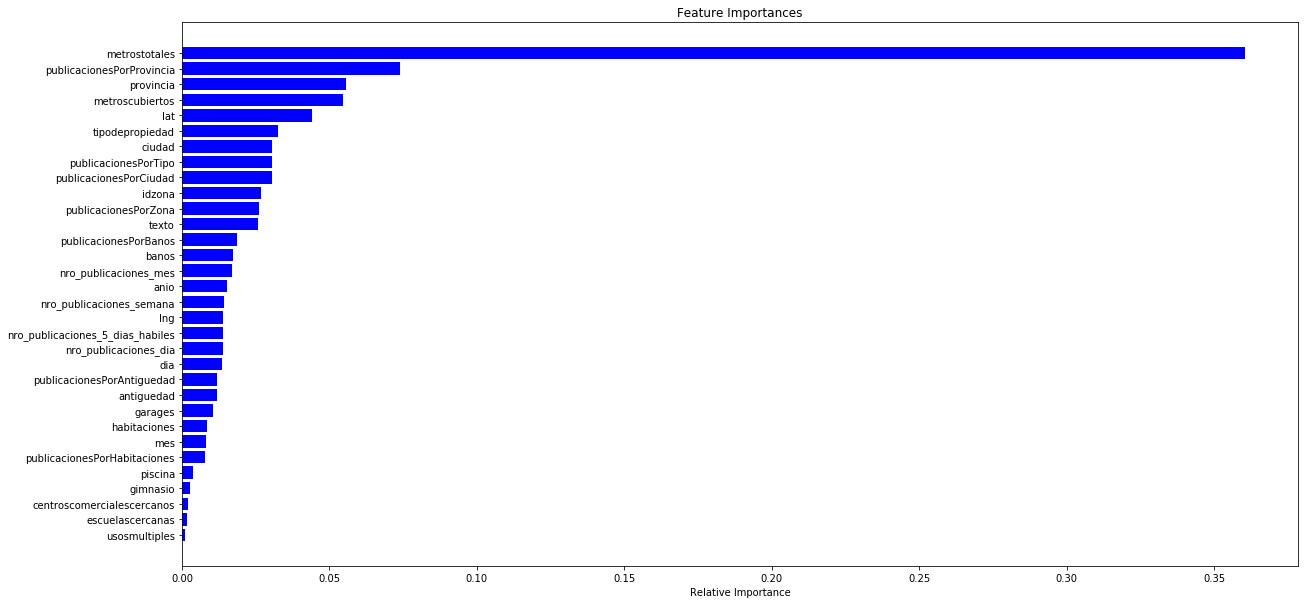

In [22]:
features = train_x.columns
importances = model.feature_importances_
indices = np.argsort(importances)
fig= plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
ping()
plt.show()

Vemos que gran part de el nmero de publicaciones no aportan mucha informacion en relacion a otros features que parecen aportar mas al precio.

In [ ]:
#Las variables categoricas las relleno indicando que estan vacias
train['ciudad'] = SimpleImputer(strategy='constant', fill_value='ciudadVacia').fit_transform(train[['ciudad']])
train['provincia'] = SimpleImputer(strategy='constant', fill_value='provinciaVacia').fit_transform(train[['provincia']])
train['tipodepropiedad'] = SimpleImputer(strategy='constant', fill_value='tipoVacio').fit_transform(train[['tipodepropiedad']])

#Las categoricas las reemplazo por la cantidad de apariciones
train['ciudad'] = CountEncoder().fit_transform(train['ciudad'])
train['provincia'] = CountEncoder().fit_transform(train['provincia'])
train['tipodepropiedad'] = CountEncoder().fit_transform(train['tipodepropiedad'])

#La antiguedad la reemplazo por el promedio de antiguedad para la ciudad
aux = train[['antiguedad', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'antiguedad':'mean'})
antiguedades = aux.T.to_dict('records').copy()
antiguedades = antiguedades[0]
train.antiguedad.fillna(train.ciudad.map(antiguedades), inplace = True)
train['antiguedad'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['antiguedad']])

#La cantidad de habitaciones las reemplazo por la mediana de habitaciones por tipo de propiedad
aux = train[['tipodepropiedad', 'habitaciones']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('tipodepropiedad').agg({'habitaciones':'median'})
habts = aux.T.to_dict('records').copy()
habts = habts[0]
train.habitaciones.fillna(train.tipodepropiedad.map(habts), inplace = True)
train['habitaciones'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['habitaciones']])

#Los garages supongo que no tiene si es nan
train.garages.fillna(0, inplace=True)
#Los banos relleno con 1 ya que es la cantidad minima de banos que tiene normalmente una propiedad
train.banos.fillna(1, inplace=True)

#Para los metros cubiertos y totales relleno con 0 y arreglo para que metros totales sea siempre mayor a metros cubiertos
aux = train.copy()
aux.metrostotales.fillna(0, inplace=True)
aux.metroscubiertos.fillna(0, inplace =True)
aux['metrostotalesCorregidos'] = aux[['metrostotales', 'metroscubiertos']].max(axis=1)
aux['metroscubiertosCorregidos'] = aux[['metrostotales', 'metroscubiertos']].min(axis=1)
train['metrostotales'] = aux['metrostotalesCorregidos']
train['metroscubiertos'] = aux['metroscubiertosCorregidos']

#El idzona lo relleno con la mediana en la ciudad
aux2 = train[['idzona', 'ciudad']].copy()
aux2.dropna(inplace = True)
aux2 = aux2.groupby('ciudad').agg({'idzona':'median'})
ids = aux2.T.to_dict('records').copy()
ids = ids[0]
train.idzona.fillna(train.ciudad.map(ids), inplace = True)
train['idzona'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['idzona']])

#Lo mismo hago para la latitud y la longitud
aux = train[['lat', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'lat':'mean'})
lats = aux.T.to_dict('records').copy()
lats = lats[0]
train.lat.fillna(train.ciudad.map(lats), inplace = True)
train['lat'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['lat']])

aux = train[['lng', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'lng':'mean'})
lngs = aux.T.to_dict('records').copy()
lngs = lngs[0]
train.lat.fillna(train.ciudad.map(lngs), inplace = True)
train['lng'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['lng']])

#La fecha la separo en 3 columnsa de anio, mes y dia
train['fecha'] = pd.to_datetime(train['fecha'])
train['dia'] = train.fecha.dt.day
train['mes'] = train.fecha.dt.month
train['anio'] = train.fecha.dt.year

train['publicacionesPorCiudad'] = CountEncoder().fit_transform(train['ciudad'])
train['publicacionesPorProvincia'] = CountEncoder().fit_transform(train['provincia'])
train['publicacionesPorTipo'] = CountEncoder().fit_transform(train['tipodepropiedad'])
train['publicacionesPorZona'] = CountEncoder().fit_transform(train['idzona'])
train['publicacionesPorBanos'] = CountEncoder().fit_transform(train['banos'])
train['publicacionesPorHabitaciones'] = CountEncoder().fit_transform(train['habitaciones'])
train['publicacionesPorAntiguedad'] = CountEncoder().fit_transform(train['antiguedad'])
train["fecha"] = pd.to_datetime(train["fecha"])
train["nro_publicaciones_dia"] = train.groupby(pd.Grouper(key='fecha', freq='D'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
train["nro_publicaciones_semana"] = train.groupby(pd.Grouper(key='fecha', freq='W'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
train["nro_publicaciones_5_dias_habiles"] = train.groupby(pd.Grouper(key='fecha', freq='B'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
train["nro_publicaciones_mes"] = train.groupby(pd.Grouper(key='fecha', freq='M'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
train.drop(columns=['fecha'], inplace=True)


In [ ]:
#Agrego features del texto
aux = df[["titulo", "descripcion"]].copy()
aux.titulo.fillna('', inplace=True)
aux.descripcion.fillna('', inplace=True)
aux["titulo_descripcion"] = aux["titulo"].astype(str) + " " + aux["descripcion"].astype(str)
#Como tiene algunos nulos los relleno con cadenas vaicas
aux["titulo_descripcion"].fillna("",inplace = True)
#REMUEVO LA PUNTUACION
import string
print(string.punctuation)
tabla = {}
for c in string.punctuation + "¿¡":
    tabla[ord(c)] = None
import string
for c in string.ascii_uppercase:
    tabla[ord(c)] = c.lower()
def sacar_puntuacion(s):
    return s.translate(tabla)

aux["titulo_descripcion"] = aux["titulo_descripcion"].apply(sacar_puntuacion)
#aux["titulo_descripcion"] = aux["titulo_descripcion"].apply(lambda x: x.lower())

#Agrego los primeros features
train["nro_palabras"] = aux["titulo_descripcion"].apply(lambda x: len(x.split(" ")))
train["nro_caracteres"] = aux["titulo_descripcion"].apply(lambda x: len(x))
train["long_prom_palabra"] = train["nro_caracteres"] / train["nro_palabras"]

def llenarDiccionario(diccionario,descripcion):
    for palabra in descripcion.split():
        diccionario[palabra] = diccionario.get(palabra,0) + 1
        
def generarDiccionario(df2):
    dicc = {}
    for descripcion in df2['titulo_descripcion']:
        if isinstance(descripcion,str): llenarDiccionario(dicc,descripcion)
    return dicc
contador_palabras = generarDiccionario(aux)


    
#Elimino las stopwords = palabras vacias que no suman nada
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
palabras_vacias = stopwords.words('spanish')
stemmer = SnowballStemmer("spanish")
from nltk.tokenize import sent_tokenize, word_tokenize 

def procesar_texto(texto):
    palabras = word_tokenize(texto)
    for indice in range(len(palabras)):
        if palabras[indice] not in palabras_vacias:
            palabras[indice] = stemmer.stem(palabras[indice])
    return palabras
#print("Voy a stemmizar")
#aux['titulo_descripcion'] = aux['titulo_descripcion'].map(procesar_texto)
#print("Termine de stemmizar")
for palabra  in palabras_vacias:
    if palabra in contador_palabras:
        del contador_palabras[palabra]
ordenados = sorted(contador_palabras.items(),key = lambda x: -x[1])
top_50 = dict(ordenados[:50])


#Nuevos features
def contar_palabras_en_top(texto):
    #palabras = texto.split()
    palabras = texto
    cont = 0
    for palabra in palabras:
        if palabra in top_50:
            cont += 1
    return cont
train["nro_palabras_mas_comunes"] = aux["titulo_descripcion"].apply(contar_palabras_en_top)

In [ ]:
train.drop(columns = ["descripcion", "titulo", "direccion"],inplace = True)

In [ ]:
train_x = train.drop(columns=['precio']).copy()
train_y = train.precio
model.fit(train_x, train_y)
features = train_x.columns
importances = model.feature_importances_
indices = np.argsort(importances)
fig= plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
ping()
plt.show()

Vemos que los features de texto ingresados no tienen mucha importancia en relacion al resto así que agregamos algunos nuevos

In [54]:
train = df.copy()

In [61]:
#Las variables categoricas las relleno indicando que estan vacias
train['ciudad'] = SimpleImputer(strategy='constant', fill_value='ciudadVacia').fit_transform(train[['ciudad']])
train['provincia'] = SimpleImputer(strategy='constant', fill_value='provinciaVacia').fit_transform(train[['provincia']])
train['tipodepropiedad'] = SimpleImputer(strategy='constant', fill_value='tipoVacio').fit_transform(train[['tipodepropiedad']])

#Las categoricas las reemplazo por la cantidad de apariciones
train['ciudad'] = CountEncoder().fit_transform(train['ciudad'])
train['provincia'] = CountEncoder().fit_transform(train['provincia'])
train['tipodepropiedad'] = CountEncoder().fit_transform(train['tipodepropiedad'])

#La antiguedad la reemplazo por el promedio de antiguedad para la ciudad
aux = train[['antiguedad', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'antiguedad':'mean'})
antiguedades = aux.T.to_dict('records').copy()
antiguedades = antiguedades[0]
train.antiguedad.fillna(train.ciudad.map(antiguedades), inplace = True)
train['antiguedad'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['antiguedad']])

#La cantidad de habitaciones las reemplazo por la mediana de habitaciones por tipo de propiedad
aux = train[['tipodepropiedad', 'habitaciones']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('tipodepropiedad').agg({'habitaciones':'median'})
habts = aux.T.to_dict('records').copy()
habts = habts[0]
train.habitaciones.fillna(train.tipodepropiedad.map(habts), inplace = True)
train['habitaciones'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['habitaciones']])

#Los garages supongo que no tiene si es nan
train.garages.fillna(0, inplace=True)
#Los banos relleno con 1 ya que es la cantidad minima de banos que tiene normalmente una propiedad
train.banos.fillna(1, inplace=True)

#Para los metros cubiertos y totales relleno con 0 y arreglo para que metros totales sea siempre mayor a metros cubiertos
aux = train.copy()
aux.metrostotales.fillna(0, inplace=True)
aux.metroscubiertos.fillna(0, inplace =True)
aux['metrostotalesCorregidos'] = aux[['metrostotales', 'metroscubiertos']].max(axis=1)
aux['metroscubiertosCorregidos'] = aux[['metrostotales', 'metroscubiertos']].min(axis=1)
train['metrostotales'] = aux['metrostotalesCorregidos']
train['metroscubiertos'] = aux['metroscubiertosCorregidos']

#El idzona lo relleno con la mediana en la ciudad
aux2 = train[['idzona', 'ciudad']].copy()
aux2.dropna(inplace = True)
aux2 = aux2.groupby('ciudad').agg({'idzona':'median'})
ids = aux2.T.to_dict('records').copy()
ids = ids[0]
train.idzona.fillna(train.ciudad.map(ids), inplace = True)
train['idzona'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['idzona']])

#Lo mismo hago para la latitud y la longitud
aux = train[['lat', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'lat':'mean'})
lats = aux.T.to_dict('records').copy()
lats = lats[0]
train.lat.fillna(train.ciudad.map(lats), inplace = True)
train['lat'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['lat']])

aux = train[['lng', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'lng':'mean'})
lngs = aux.T.to_dict('records').copy()
lngs = lngs[0]
train.lat.fillna(train.ciudad.map(lngs), inplace = True)
train['lng'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['lng']])

#La fecha la separo en 3 columnsa de anio, mes y dia
train['fecha'] = pd.to_datetime(train['fecha'])
train['dia'] = train.fecha.dt.day
train['mes'] = train.fecha.dt.month
train['anio'] = train.fecha.dt.year

#train['publicacionesPorCiudad'] = CountEncoder().fit_transform(train['ciudad'])
#train['publicacionesPorProvincia'] = CountEncoder().fit_transform(train['provincia'])
#train['publicacionesPorTipo'] = CountEncoder().fit_transform(train['tipodepropiedad'])
#train['publicacionesPorZona'] = CountEncoder().fit_transform(train['idzona'])
#train['publicacionesPorBanos'] = CountEncoder().fit_transform(train['banos'])
#train['publicacionesPorHabitaciones'] = CountEncoder().fit_transform(train['habitaciones'])
#train['publicacionesPorAntiguedad'] = CountEncoder().fit_transform(train['antiguedad'])
train["fecha"] = pd.to_datetime(train["fecha"])
#train["nro_publicaciones_dia"] = train.groupby(pd.Grouper(key='fecha', freq='D'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
#train["nro_publicaciones_semana"] = train.groupby(pd.Grouper(key='fecha', freq='W'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
#train["nro_publicaciones_5_dias_habiles"] = train.groupby(pd.Grouper(key='fecha', freq='B'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
#train["nro_publicaciones_mes"] = train.groupby(pd.Grouper(key='fecha', freq='M'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
train.drop(columns=['fecha'], inplace=True)


ValueError: 'fill_value'=ciudadVacia is invalid. Expected a numerical value when imputing numerical data

In [56]:
#Agrego features del texto
aux = train[["titulo", "descripcion"]].copy()
aux.titulo.fillna('', inplace=True)
aux.descripcion.fillna('', inplace=True)
aux["titulo_descripcion"] = aux["titulo"].astype(str) + " " + aux["descripcion"].astype(str)
#Como tiene algunos nulos los relleno con cadenas vaicas
aux["titulo_descripcion"].fillna("",inplace = True)
#REMUEVO LA PUNTUACION
import string
print(string.punctuation)
tabla = {}
for c in string.punctuation + "¿¡":
    tabla[ord(c)] = None
import string
for c in string.ascii_uppercase:
    tabla[ord(c)] = c.lower()
def sacar_puntuacion(s):
    return s.translate(tabla)

aux["titulo_descripcion"] = aux["titulo_descripcion"].apply(sacar_puntuacion)
#aux["titulo_descripcion"] = aux["titulo_descripcion"].apply(lambda x: x.lower())

#Agrego los primeros features
train["nro_palabras"] = aux["titulo_descripcion"].apply(lambda x: len(x.split(" ")))
train["nro_caracteres"] = aux["titulo_descripcion"].apply(lambda x: len(x))
train["long_prom_palabra"] = train["nro_caracteres"] / train["nro_palabras"]

def llenarDiccionario(diccionario,descripcion):
    for palabra in descripcion.split():
        diccionario[palabra] = diccionario.get(palabra,0) + 1
        
def generarDiccionario(df2):
    dicc = {}
    for descripcion in df2['titulo_descripcion']:
        if isinstance(descripcion,str): llenarDiccionario(dicc,descripcion)
    return dicc
contador_palabras = generarDiccionario(aux)


    
#Elimino las stopwords = palabras vacias que no suman nada
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
palabras_vacias = stopwords.words('spanish')
stemmer = SnowballStemmer("spanish")
from nltk.tokenize import sent_tokenize, word_tokenize 

def procesar_texto(texto):
    palabras = word_tokenize(texto)
    resultado = []
    for indice in range(len(palabras)):
        #if palabras[indice] not in palabras_vacias:
        #    palabras[indice] = stemmer.stem(palabras[indice])
        if palabras[indice] in palabras_vacias:
            continue
        resultado.append(palabras[indice])

    return resultado
#print("Voy a stemmizar")
#aux['titulo_descripcion'] = aux['titulo_descripcion'].map(procesar_texto)
#print("Termine de stemmizar")
for palabra  in palabras_vacias:
    if palabra in contador_palabras:
        del contador_palabras[palabra]
ordenados = sorted(contador_palabras.items(),key = lambda x: -x[1])
top_50 = dict(ordenados[:50])


#Nuevos features
def contar_palabras_en_top(texto):
    #palabras = texto.split()
    palabras = texto
    cont = 0
    for palabra in palabras:
        if palabra in top_50:
            cont += 1
    return cont

def contar_palabras_en_top_unicas(texto):
    d = {}
    for palabra in palabras:
        if palabra in top_50:
            d[palabra] = 1
    return len(d.keys())
train["nro_palabras_mas_comunes"] = aux["titulo_descripcion"].apply(contar_palabras_en_top)


!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [57]:
aux['tipodepropiedad'] = df["tipodepropiedad"].copy()
def obtenerTop50(serie):
    top = {}
    for texto in serie:
        if isinstance(texto,str): llenarDiccionario(top,texto)
    for palabra  in palabras_vacias:
        if palabra in top:
            del top[palabra]
    ordenados = sorted(top.items(),key = lambda x: -x[1])
    return dict(ordenados[:50])

    
tops = aux.groupby('tipodepropiedad').agg({"titulo_descripcion": obtenerTop50})
tops = tops['titulo_descripcion'].to_dict()

In [58]:
def contarPalabrasEnTopTipo(df):
    descripcion = df['titulo_descripcion']
    tipo = df['tipodepropiedad']
    cont = 0
    for palabra in descripcion:
        if palabra in tops[tipo]:
            cont += 1
    return cont
aux['tipodepropiedad'] = SimpleImputer(strategy='most_frequent').fit_transform(aux[['tipodepropiedad']])
train['cantPalabrasComunesPorTipo'] = aux.apply(contarPalabrasEnTopTipo, axis = 1)

In [59]:
train.drop(columns = ["descripcion", "titulo", "direccion", "escuelascercanas", "centroscomercialescercanos", "gimnasio", "piscina"],inplace = True)

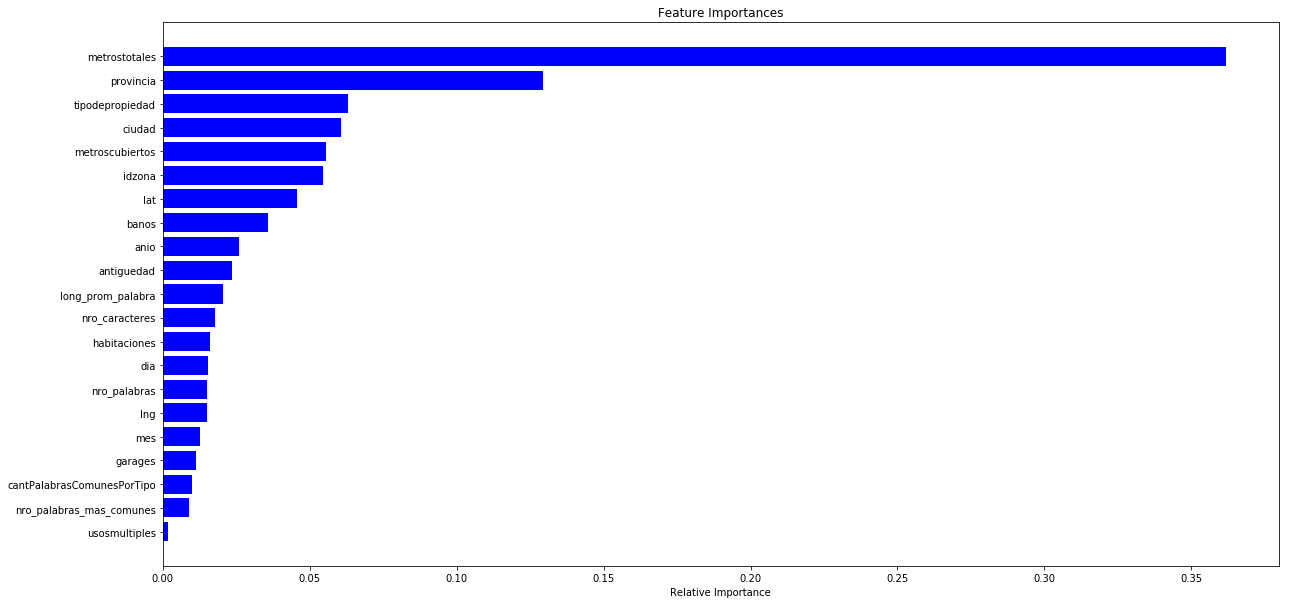

In [63]:
train_x = train.drop(columns=['precio']).copy()
train_y = train.precio
model.fit(train_x, train_y)
features = train_x.columns
importances = model.feature_importances_
indices = np.argsort(importances)
fig= plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
ping()
plt.show()

Veo si rellenando las palabras mas comunes con las apariciones unicas logro algo que sean minimamente mas relevantes

In [65]:
train = df.copy()

In [66]:
#Las variables categoricas las relleno indicando que estan vacias
train['ciudad'] = SimpleImputer(strategy='constant', fill_value='ciudadVacia').fit_transform(train[['ciudad']])
train['provincia'] = SimpleImputer(strategy='constant', fill_value='provinciaVacia').fit_transform(train[['provincia']])
train['tipodepropiedad'] = SimpleImputer(strategy='constant', fill_value='tipoVacio').fit_transform(train[['tipodepropiedad']])

#Las categoricas las reemplazo por la cantidad de apariciones
train['ciudad'] = CountEncoder().fit_transform(train['ciudad'])
train['provincia'] = CountEncoder().fit_transform(train['provincia'])
train['tipodepropiedad'] = CountEncoder().fit_transform(train['tipodepropiedad'])

#La antiguedad la reemplazo por el promedio de antiguedad para la ciudad
aux = train[['antiguedad', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'antiguedad':'mean'})
antiguedades = aux.T.to_dict('records').copy()
antiguedades = antiguedades[0]
train.antiguedad.fillna(train.ciudad.map(antiguedades), inplace = True)
train['antiguedad'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['antiguedad']])

#La cantidad de habitaciones las reemplazo por la mediana de habitaciones por tipo de propiedad
aux = train[['tipodepropiedad', 'habitaciones']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('tipodepropiedad').agg({'habitaciones':'median'})
habts = aux.T.to_dict('records').copy()
habts = habts[0]
train.habitaciones.fillna(train.tipodepropiedad.map(habts), inplace = True)
train['habitaciones'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['habitaciones']])

#Los garages supongo que no tiene si es nan
train.garages.fillna(0, inplace=True)
#Los banos relleno con 1 ya que es la cantidad minima de banos que tiene normalmente una propiedad
train.banos.fillna(1, inplace=True)

#Para los metros cubiertos y totales relleno con 0 y arreglo para que metros totales sea siempre mayor a metros cubiertos
aux = train.copy()
aux.metrostotales.fillna(0, inplace=True)
aux.metroscubiertos.fillna(0, inplace =True)
aux['metrostotalesCorregidos'] = aux[['metrostotales', 'metroscubiertos']].max(axis=1)
aux['metroscubiertosCorregidos'] = aux[['metrostotales', 'metroscubiertos']].min(axis=1)
train['metrostotales'] = aux['metrostotalesCorregidos']
train['metroscubiertos'] = aux['metroscubiertosCorregidos']

#El idzona lo relleno con la mediana en la ciudad
aux2 = train[['idzona', 'ciudad']].copy()
aux2.dropna(inplace = True)
aux2 = aux2.groupby('ciudad').agg({'idzona':'median'})
ids = aux2.T.to_dict('records').copy()
ids = ids[0]
train.idzona.fillna(train.ciudad.map(ids), inplace = True)
train['idzona'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['idzona']])

#Lo mismo hago para la latitud y la longitud
aux = train[['lat', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'lat':'mean'})
lats = aux.T.to_dict('records').copy()
lats = lats[0]
train.lat.fillna(train.ciudad.map(lats), inplace = True)
train['lat'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['lat']])

aux = train[['lng', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'lng':'mean'})
lngs = aux.T.to_dict('records').copy()
lngs = lngs[0]
train.lat.fillna(train.ciudad.map(lngs), inplace = True)
train['lng'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['lng']])

#La fecha la separo en 3 columnsa de anio, mes y dia
train['fecha'] = pd.to_datetime(train['fecha'])
train['dia'] = train.fecha.dt.day
train['mes'] = train.fecha.dt.month
train['anio'] = train.fecha.dt.year

#train['publicacionesPorCiudad'] = CountEncoder().fit_transform(train['ciudad'])
#train['publicacionesPorProvincia'] = CountEncoder().fit_transform(train['provincia'])
#train['publicacionesPorTipo'] = CountEncoder().fit_transform(train['tipodepropiedad'])
#train['publicacionesPorZona'] = CountEncoder().fit_transform(train['idzona'])
#train['publicacionesPorBanos'] = CountEncoder().fit_transform(train['banos'])
#train['publicacionesPorHabitaciones'] = CountEncoder().fit_transform(train['habitaciones'])
#train['publicacionesPorAntiguedad'] = CountEncoder().fit_transform(train['antiguedad'])
train["fecha"] = pd.to_datetime(train["fecha"])
#train["nro_publicaciones_dia"] = train.groupby(pd.Grouper(key='fecha', freq='D'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
#train["nro_publicaciones_semana"] = train.groupby(pd.Grouper(key='fecha', freq='W'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
#train["nro_publicaciones_5_dias_habiles"] = train.groupby(pd.Grouper(key='fecha', freq='B'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
#train["nro_publicaciones_mes"] = train.groupby(pd.Grouper(key='fecha', freq='M'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
train.drop(columns=['fecha'], inplace=True)


In [68]:
#Agrego features del texto
aux = train[["titulo", "descripcion"]].copy()
aux.titulo.fillna('', inplace=True)
aux.descripcion.fillna('', inplace=True)
aux["titulo_descripcion"] = aux["titulo"].astype(str) + " " + aux["descripcion"].astype(str)
#Como tiene algunos nulos los relleno con cadenas vaicas
aux["titulo_descripcion"].fillna("",inplace = True)
#REMUEVO LA PUNTUACION
import string
print(string.punctuation)
tabla = {}
for c in string.punctuation + "¿¡":
    tabla[ord(c)] = None
import string
for c in string.ascii_uppercase:
    tabla[ord(c)] = c.lower()
def sacar_puntuacion(s):
    return s.translate(tabla)

aux["titulo_descripcion"] = aux["titulo_descripcion"].apply(sacar_puntuacion)
#aux["titulo_descripcion"] = aux["titulo_descripcion"].apply(lambda x: x.lower())

#Agrego los primeros features
train["nro_palabras"] = aux["titulo_descripcion"].apply(lambda x: len(x.split(" ")))
train["nro_caracteres"] = aux["titulo_descripcion"].apply(lambda x: len(x))
train["long_prom_palabra"] = train["nro_caracteres"] / train["nro_palabras"]

def llenarDiccionario(diccionario,descripcion):
    for palabra in descripcion.split():
        diccionario[palabra] = diccionario.get(palabra,0) + 1
        
def generarDiccionario(df2):
    dicc = {}
    for descripcion in df2['titulo_descripcion']:
        if isinstance(descripcion,str): llenarDiccionario(dicc,descripcion)
    return dicc
contador_palabras = generarDiccionario(aux)


    
#Elimino las stopwords = palabras vacias que no suman nada
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
palabras_vacias = stopwords.words('spanish')
stemmer = SnowballStemmer("spanish")
from nltk.tokenize import sent_tokenize, word_tokenize 

def procesar_texto(texto):
    palabras = word_tokenize(texto)
    resultado = []
    for indice in range(len(palabras)):
        #if palabras[indice] not in palabras_vacias:
        #    palabras[indice] = stemmer.stem(palabras[indice])
        if palabras[indice] in palabras_vacias:
            continue
        resultado.append(palabras[indice])

    return resultado
#print("Voy a stemmizar")
#aux['titulo_descripcion'] = aux['titulo_descripcion'].map(procesar_texto)
#print("Termine de stemmizar")
for palabra  in palabras_vacias:
    if palabra in contador_palabras:
        del contador_palabras[palabra]
ordenados = sorted(contador_palabras.items(),key = lambda x: -x[1])
top_50 = dict(ordenados[:50])

def contar_palabras_en_top_unicas(texto):
    d = {}
    for palabra in texto:
        if palabra in top_50:
            d[palabra] = 1
    return len(d.keys())
train["nro_palabras_mas_comunes"] = aux["titulo_descripcion"].apply(contar_palabras_en_top_unicas)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [69]:
aux['tipodepropiedad'] = df["tipodepropiedad"].copy()
def obtenerTop50(serie):
    top = {}
    for texto in serie:
        if isinstance(texto,str): llenarDiccionario(top,texto)
    for palabra  in palabras_vacias:
        if palabra in top:
            del top[palabra]
    ordenados = sorted(top.items(),key = lambda x: -x[1])
    return dict(ordenados[:50])

    
tops = aux.groupby('tipodepropiedad').agg({"titulo_descripcion": obtenerTop50})
tops = tops['titulo_descripcion'].to_dict()

def contarPalabrasEnTopTipo(df):
    descripcion = df['titulo_descripcion']
    tipo = df['tipodepropiedad']
    d = {}
    for palabra in descripcion:
        if palabra in tops[tipo]:
            d[palabra] = 1
    return len(d.keys())
aux['tipodepropiedad'] = SimpleImputer(strategy='most_frequent').fit_transform(aux[['tipodepropiedad']])
train['cantPalabrasComunesPorTipo'] = aux.apply(contarPalabrasEnTopTipo, axis = 1)

In [70]:
train.drop(columns = ["descripcion", "titulo", "direccion", "escuelascercanas", "centroscomercialescercanos", "gimnasio", "piscina"],inplace = True)

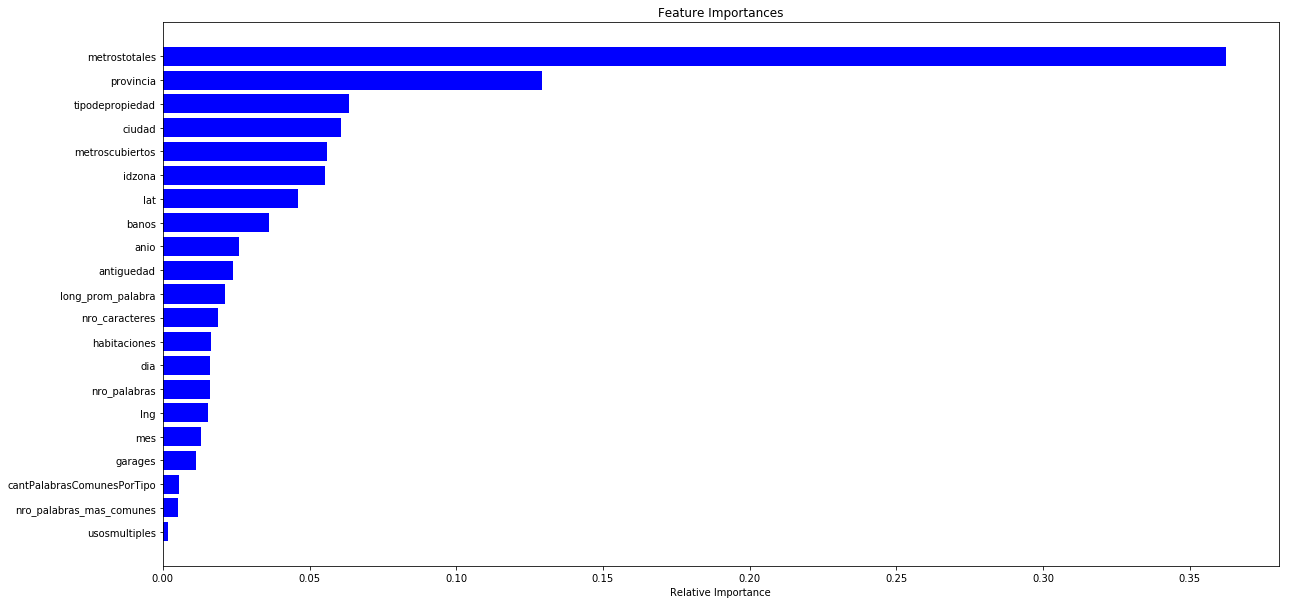

In [71]:
train_x = train.drop(columns=['precio']).copy()
train_y = train.precio
model.fit(train_x, train_y)
features = train_x.columns
importances = model.feature_importances_
indices = np.argsort(importances)
fig= plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
ping()
plt.show()

Vemos que no dio una mejora significativa ni de cerca cambiando a los valores unicos

Como podemos observar rellenar los banos de esta manera no cambia la feature importance

Ahora probamos con el catBoostEncoder para la ciudad, la provincia y el tipo de propiedad y verificamos como afecta la feature importance

In [84]:
train = df.copy()

In [74]:
train['ciudad'] = CatBoostEncoder().fit_transform(train['ciudad'], df['precio'])
train['provincia'] = CatBoostEncoder().fit_transform(train['provincia'], df['precio'])
train['tipodepropiedad'] = CatBoostEncoder().fit_transform(train['tipodepropiedad'], df['precio'])

In [75]:
#La antiguedad la reemplazo por el promedio de antiguedad para la ciudad
aux = train[['antiguedad', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'antiguedad':'mean'})
antiguedades = aux.T.to_dict('records').copy()
antiguedades = antiguedades[0]
train.antiguedad.fillna(train.ciudad.map(antiguedades), inplace = True)
train['antiguedad'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['antiguedad']])

#La cantidad de habitaciones las reemplazo por la mediana de habitaciones por tipo de propiedad
aux = train[['tipodepropiedad', 'habitaciones']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('tipodepropiedad').agg({'habitaciones':'median'})
habts = aux.T.to_dict('records').copy()
habts = habts[0]
train.habitaciones.fillna(train.tipodepropiedad.map(habts), inplace = True)
train['habitaciones'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['habitaciones']])

#Los garages supongo que no tiene si es nan
train.garages.fillna(0, inplace=True)
#Los banos relleno con 1 ya que es la cantidad minima de banos que tiene normalmente una propiedad
train.banos.fillna(1, inplace=True)

#Para los metros cubiertos y totales relleno con 0 y arreglo para que metros totales sea siempre mayor a metros cubiertos
aux = train.copy()
aux.metrostotales.fillna(0, inplace=True)
aux.metroscubiertos.fillna(0, inplace =True)
aux['metrostotalesCorregidos'] = aux[['metrostotales', 'metroscubiertos']].max(axis=1)
aux['metroscubiertosCorregidos'] = aux[['metrostotales', 'metroscubiertos']].min(axis=1)
train['metrostotales'] = aux['metrostotalesCorregidos']
train['metroscubiertos'] = aux['metroscubiertosCorregidos']

#El idzona lo relleno con la mediana en la ciudad
aux2 = train[['idzona', 'ciudad']].copy()
aux2.dropna(inplace = True)
aux2 = aux2.groupby('ciudad').agg({'idzona':'median'})
ids = aux2.T.to_dict('records').copy()
ids = ids[0]
train.idzona.fillna(train.ciudad.map(ids), inplace = True)
train['idzona'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['idzona']])

#Lo mismo hago para la latitud y la longitud
aux = train[['lat', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'lat':'mean'})
lats = aux.T.to_dict('records').copy()
lats = lats[0]
train.lat.fillna(train.ciudad.map(lats), inplace = True)
train['lat'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['lat']])

aux = train[['lng', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'lng':'mean'})
lngs = aux.T.to_dict('records').copy()
lngs = lngs[0]
train.lat.fillna(train.ciudad.map(lngs), inplace = True)
train['lng'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['lng']])

#La fecha la separo en 3 columnsa de anio, mes y dia
train['fecha'] = pd.to_datetime(train['fecha'])
train['dia'] = train.fecha.dt.day
train['mes'] = train.fecha.dt.month
train['anio'] = train.fecha.dt.year

#train['publicacionesPorCiudad'] = CountEncoder().fit_transform(train['ciudad'])
#train['publicacionesPorProvincia'] = CountEncoder().fit_transform(train['provincia'])
#train['publicacionesPorTipo'] = CountEncoder().fit_transform(train['tipodepropiedad'])
#train['publicacionesPorZona'] = CountEncoder().fit_transform(train['idzona'])
#train['publicacionesPorBanos'] = CountEncoder().fit_transform(train['banos'])
#train['publicacionesPorHabitaciones'] = CountEncoder().fit_transform(train['habitaciones'])
#train['publicacionesPorAntiguedad'] = CountEncoder().fit_transform(train['antiguedad'])
train["fecha"] = pd.to_datetime(train["fecha"])
#train["nro_publicaciones_dia"] = train.groupby(pd.Grouper(key='fecha', freq='D'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
#train["nro_publicaciones_semana"] = train.groupby(pd.Grouper(key='fecha', freq='W'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
#train["nro_publicaciones_5_dias_habiles"] = train.groupby(pd.Grouper(key='fecha', freq='B'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
#train["nro_publicaciones_mes"] = train.groupby(pd.Grouper(key='fecha', freq='M'))["publicacionesPorAntiguedad"].transform(lambda x: len(x.index))
train.drop(columns=['fecha'], inplace=True)


In [76]:
#Agrego features del texto
aux = train[["titulo", "descripcion"]].copy()
aux.titulo.fillna('', inplace=True)
aux.descripcion.fillna('', inplace=True)
aux["titulo_descripcion"] = aux["titulo"].astype(str) + " " + aux["descripcion"].astype(str)
#Como tiene algunos nulos los relleno con cadenas vaicas
aux["titulo_descripcion"].fillna("",inplace = True)
#REMUEVO LA PUNTUACION
import string
print(string.punctuation)
tabla = {}
for c in string.punctuation + "¿¡":
    tabla[ord(c)] = None
import string
for c in string.ascii_uppercase:
    tabla[ord(c)] = c.lower()
def sacar_puntuacion(s):
    return s.translate(tabla)

aux["titulo_descripcion"] = aux["titulo_descripcion"].apply(sacar_puntuacion)
#aux["titulo_descripcion"] = aux["titulo_descripcion"].apply(lambda x: x.lower())

#Agrego los primeros features
train["nro_palabras"] = aux["titulo_descripcion"].apply(lambda x: len(x.split(" ")))
train["nro_caracteres"] = aux["titulo_descripcion"].apply(lambda x: len(x))
train["long_prom_palabra"] = train["nro_caracteres"] / train["nro_palabras"]

def llenarDiccionario(diccionario,descripcion):
    for palabra in descripcion.split():
        diccionario[palabra] = diccionario.get(palabra,0) + 1
        
def generarDiccionario(df2):
    dicc = {}
    for descripcion in df2['titulo_descripcion']:
        if isinstance(descripcion,str): llenarDiccionario(dicc,descripcion)
    return dicc
contador_palabras = generarDiccionario(aux)


    
#Elimino las stopwords = palabras vacias que no suman nada
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
palabras_vacias = stopwords.words('spanish')
stemmer = SnowballStemmer("spanish")
from nltk.tokenize import sent_tokenize, word_tokenize 

def procesar_texto(texto):
    palabras = word_tokenize(texto)
    resultado = []
    for indice in range(len(palabras)):
        #if palabras[indice] not in palabras_vacias:
        #    palabras[indice] = stemmer.stem(palabras[indice])
        if palabras[indice] in palabras_vacias:
            continue
        resultado.append(palabras[indice])

    return resultado
#print("Voy a stemmizar")
#aux['titulo_descripcion'] = aux['titulo_descripcion'].map(procesar_texto)
#print("Termine de stemmizar")
for palabra  in palabras_vacias:
    if palabra in contador_palabras:
        del contador_palabras[palabra]
ordenados = sorted(contador_palabras.items(),key = lambda x: -x[1])
top_50 = dict(ordenados[:50])

def contar_palabras_en_top_unicas(texto):
    d = {}
    for palabra in texto:
        if palabra in top_50:
            d[palabra] = 1
    return len(d.keys())
train["nro_palabras_mas_comunes"] = aux["titulo_descripcion"].apply(contar_palabras_en_top_unicas)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [77]:
aux['tipodepropiedad'] = df["tipodepropiedad"].copy()
def obtenerTop50(serie):
    top = {}
    for texto in serie:
        if isinstance(texto,str): llenarDiccionario(top,texto)
    for palabra  in palabras_vacias:
        if palabra in top:
            del top[palabra]
    ordenados = sorted(top.items(),key = lambda x: -x[1])
    return dict(ordenados[:50])

    
tops = aux.groupby('tipodepropiedad').agg({"titulo_descripcion": obtenerTop50})
tops = tops['titulo_descripcion'].to_dict()

def contarPalabrasEnTopTipo(df):
    descripcion = df['titulo_descripcion']
    tipo = df['tipodepropiedad']
    d = {}
    for palabra in descripcion:
        if palabra in tops[tipo]:
            d[palabra] = 1
    return len(d.keys())
aux['tipodepropiedad'] = SimpleImputer(strategy='most_frequent').fit_transform(aux[['tipodepropiedad']])
train['cantPalabrasComunesPorTipo'] = aux.apply(contarPalabrasEnTopTipo, axis = 1)

In [78]:
train.drop(columns = ["descripcion", "titulo", "direccion", "escuelascercanas", "centroscomercialescercanos", "gimnasio", "piscina"],inplace = True)

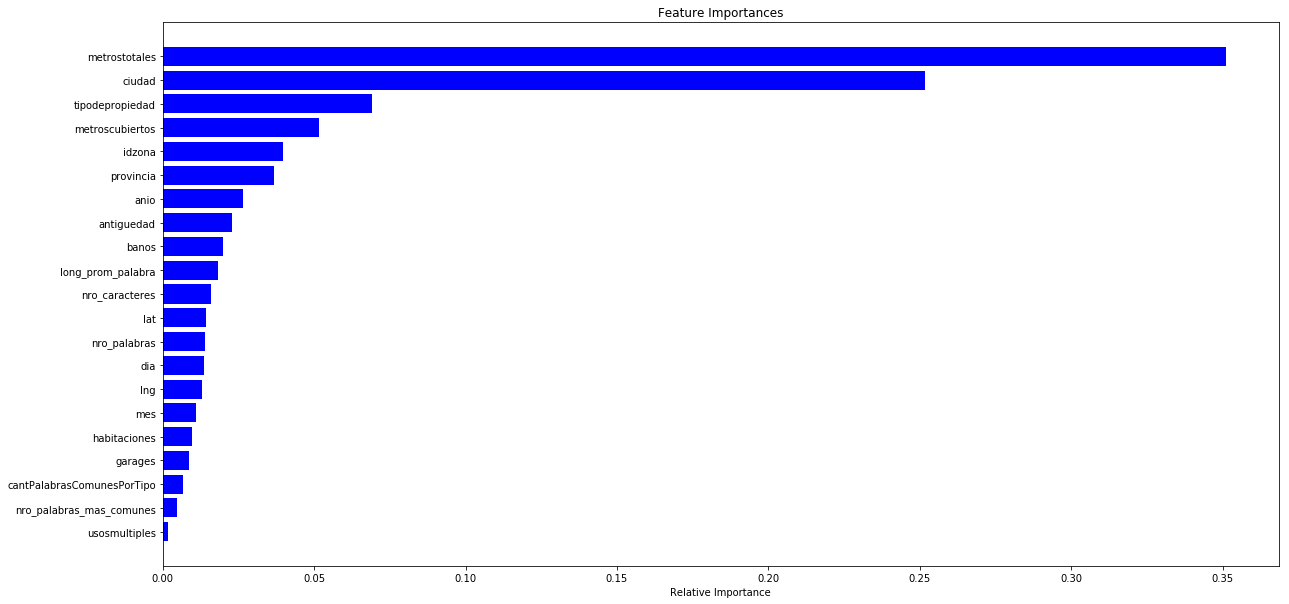

In [81]:
train_x = train.drop(columns=['precio']).copy()
train_y = train.precio
model.fit(train_x, train_y)
features = train_x.columns
importances = model.feature_importances_
indices = np.argsort(importances)
fig= plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
ping()
plt.show()

Podemos observar que aumento la feature importance para la ciudad, el tipo de propiedad no se vio afectado mientras que la provincia decayo.
Por lo tanto, probamos con solo utilizar cat boost para la ciudad

In [ ]:
train['ciudad'] = df['ciudad']
train['provincia'] = df['provincia']
train['tipodepropiedad'] = df['tipodepropiedad']

In [ ]:
train['ciudad'] = CatBoostEncoder().fit_transform(train['ciudad'], df['precio'])
train['provincia'] = CountEncoder().fit_transform(train['provincia'])
train['tipodepropiedad'] = CountEncoder().fit_transform(train['tipodepropiedad'])

In [ ]:
train_x = train.drop(columns=['precio']).copy()
train_y = train.precio
model.fit(train_x, train_y)
features = train_x.columns
importances = model.feature_importances_
indices = np.argsort(importances)
fig= plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
ping()
plt.show()

Sorprendentemente la provincia sigue empeorando su feature importance por mas que se utilice count encoding para la provincia si se sigue usando cat boost encoder para ciudad

Ahora probamos con crear alguno features para verificar que nivel de importancia tienen y como afectan a los demas features

In [ ]:
#Agregamos la cantidad de publicaciones por mes
aux = train[['mes', 'anio']].copy()
aux['cantidad'] =  1
aux['cantidad'] = aux.groupby(['mes', 'anio']).transform('sum')
train['publicacionesEnMes'] = aux['cantidad']

In [ ]:
aux = train[['metrostotales', 'tipodepropiedad']].copy()
aux['metrosPromedioPorTipo'] = aux.groupby('tipodepropiedad').transform('mean')
train['metrosPromedioPorTipo'] = aux['metrosPromedioPorTipo']

In [ ]:
aux = train[['metrostotales', 'ciudad']].copy()
aux['metrosPromedioPorCiudad'] = aux.groupby('ciudad').transform('mean')
train['metrosPromedioPorCiudad'] = aux['metrosPromedioPorCiudad']

In [ ]:
train_x = train.drop(columns=['precio']).copy()
train_y = train.precio
model.fit(train_x, train_y)

In [ ]:
features = train_x.columns
importances = model.feature_importances_
indices = np.argsort(importances)
fig= plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Ahora agregamos features generados a partir de los precios

In [ ]:
aux = train[['precio', 'ciudad', 'metrostotales']].copy()
aux['precioMetro'] = aux['precio']/aux['metrostotales']
aux = aux.groupby('ciudad').agg({'precioMetro':'mean'})
precioPromedio = aux.T.to_dict('records').copy()
precioPromedio = precioPromedio[0]
train['precioPromedioM2PorCiudad'] = train.ciudad.map(precioPromedio)

In [ ]:
aux = train[['precio', 'tipodepropiedad', 'metrostotales']].copy()
aux['precioMetro'] = aux['precio']/aux['metrostotales']
aux = aux.groupby('tipodepropiedad').agg({'precioMetro':'mean'})
precioPromedio = aux.T.to_dict('records').copy()
precioPromedio = precioPromedio[0]
train['precioPromedioM2PorTipo'] = train.tipodepropiedad.map(precioPromedio)

In [ ]:
aux = train[['precio', 'idzona', 'metrostotales']].copy()
aux['precioMetro'] = aux['precio']/aux['metrostotales']
aux = aux.groupby('idzona').agg({'precioMetro':'mean'})
precioPromedio = aux.T.to_dict('records').copy()
precioPromedio = precioPromedio[0]
train['precioPromedioM2PorZona'] = train.idzona.map(precioPromedio)

In [ ]:
aux = train[['precio', 'mes', 'anio', 'metrostotales']].copy()
aux['mes-anio'] = aux.mes + aux.anio
aux['precioMetro'] = aux['precio']/aux['metrostotales']
aux = aux.groupby('mes-anio').agg({'precioMetro':'mean'})
precioPromedio = aux.T.to_dict('records').copy()
precioPromedio = precioPromedio[0]
train['mes-anio'] = train.mes + train.anio
train['precioPromedioM2PorMes'] = train['mes-anio'].map(precioPromedio)
train.drop(columns=['mes-anio'], inplace = True)

In [ ]:
train_x = train.drop(columns=['precio']).copy()
train_y = train.precio
model.fit(train_x, train_y)

In [ ]:
features = train_x.columns
importances = model.feature_importances_
indices = np.argsort(importances)
fig= plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()